# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import random
import ast
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Number of rows in azidias
azidias_nrows = (len(azdias))

# Number of columns in azidias
azidias_ncolumns = (len(azdias.columns))

# Number of rows in feat_info
feat_info_nrows = (len(feat_info))

# Number of columns in feat_info
feat_info_ncolumns = (len(feat_info.columns))

# Print the number of rows and columns in azidias and feat_info
print("The total number of rows in azidias: {}".format(azidias_nrows))
print("The total number of columns in azidias: {}".format(azidias_ncolumns))
print("The total number of rows in feat_info: {}".format(feat_info_nrows))
print("The total number of columns in feat_info: {}".format(feat_info_ncolumns))

The total number of rows in azidias: 891221
The total number of columns in azidias: 85
The total number of rows in feat_info: 85
The total number of columns in feat_info: 4


In [4]:
# First 5 records of azidias
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Description of azidias
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
# First 5 records of feat_info
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,PLZ8_ANTG2,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
 
for i, column in enumerate(azdias.columns):
    str_n = feat_info['missing_or_unknown'].iloc[i]
    if i in [57, 58, 59]:
        list_n = str_n[1: -1].split(',')
    else:
        list_n = ast.literal_eval(str_n)
    for num in list_n:
        azdias[column].replace(num, np.NaN, inplace = True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.



In [10]:
# Percentage of missing data per column over 10%

null_count = azdias.isnull().sum()
null_percent = null_count / len(azdias) * 100

In [11]:
# Count of missing data per column with missing value percentages over 10%
null_count[null_percent > 10]

AGER_TYP                 685843
GEBURTSJAHR              392318
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
SHOPPER_TYP              111196
TITEL_KZ                 889061
VERS_TYP                 111196
ALTER_HH                 310267
KK_KUNDENTYP             584612
W_KEIT_KIND_HH           147988
ANZ_HAUSHALTE_AKTIV       99611
ANZ_HH_TITEL              97008
GEBAEUDETYP               93148
MIN_GEBAEUDEJAHR          93148
OST_WEST_KZ               93148
WOHNLAGE                  93148
CAMEO_DEUG_2015           99352
CAMEO_DEU_2015            99352
CAMEO_INTL_2015           99352
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_BAUMAX             476524
KBA05_GBZ                133324
BALLRAUM                  93740
EWDICHTE                  93740
INNENSTADT                93740
GEBAEUDE

In [12]:

null_percent[null_percent > 10]

AGER_TYP                 76.955435
GEBURTSJAHR              44.020282
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
SHOPPER_TYP              12.476816
TITEL_KZ                 99.757636
VERS_TYP                 12.476816
ALTER_HH                 34.813699
KK_KUNDENTYP             65.596749
W_KEIT_KIND_HH           16.605084
ANZ_HAUSHALTE_AKTIV      11.176913
ANZ_HH_TITEL             10.884842
GEBAEUDETYP              10.451729
MIN_GEBAEUDEJAHR         10.451729
OST_WEST_KZ              10.451729
WOHNLAGE                 10.451729
CAMEO_DEUG_2015          11.147852
CAMEO_DEU_2015           11.147852
CAMEO_INTL_2015          11.147852
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
KBA05_ANTG4              14.959701
KBA05_BAUMAX             53.468668
KBA05_GBZ                14.959701
BALLRAUM            

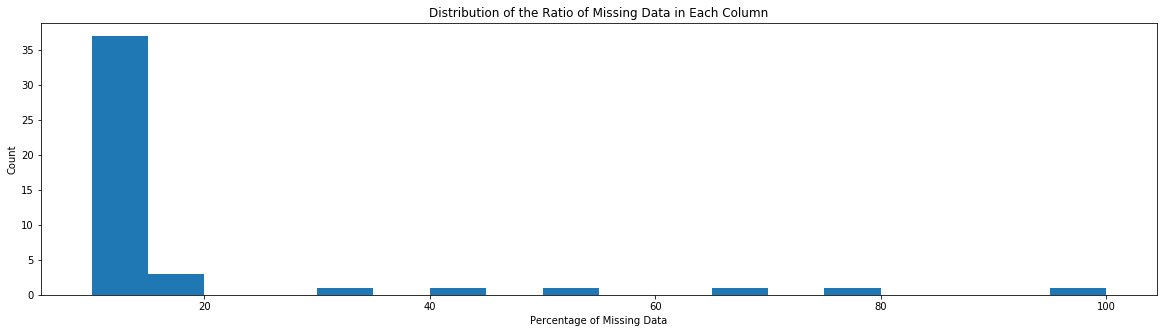

In [13]:
# Investigate patterns in the amount of missing data in each column.

plt.figure(figsize=(20,5))
plt.title('Distribution of the Ratio of Missing Data in Each Column')
plt.hist(null_percent, bins = np.linspace(10,100,19))
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Count')
plt.show()

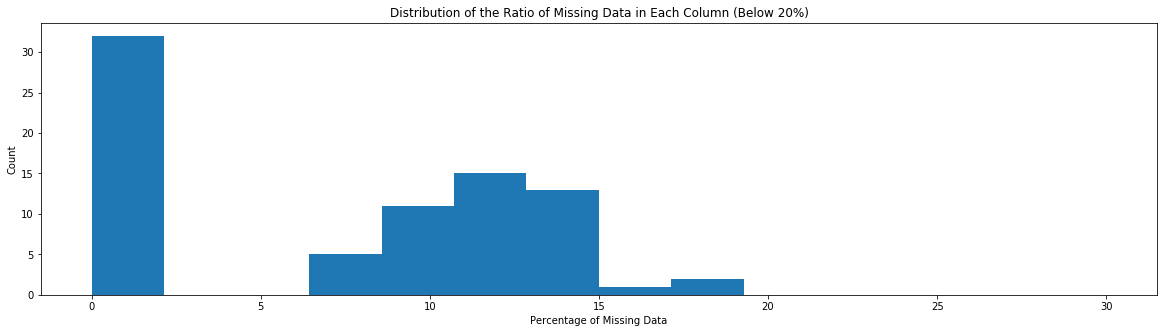

In [14]:
plt.figure(figsize=(20,5))
plt.title('Distribution of the Ratio of Missing Data in Each Column (Below 20%)')
plt.hist(null_percent, bins = np.linspace(0,30,15))
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Count')
plt.show()

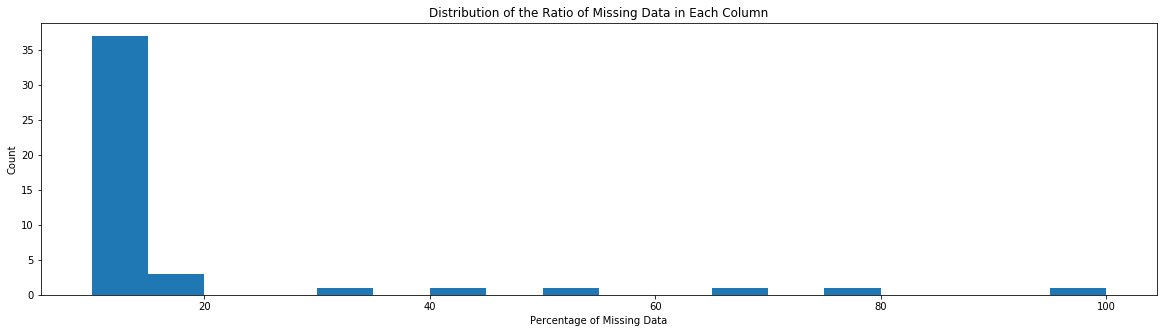

In [15]:
plt.figure(figsize=(20,5))
plt.title('Distribution of the Ratio of Missing Data in Each Column')
plt.hist(null_percent, bins = np.linspace(10,100,19))
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Count')
plt.show()

In [16]:
i_5, i_10, i_15, i_20 = 0,0,0,0

for value in null_count:
    if(50000 <= value <= 100000):
        i_5+=1
    elif(100000 <= value <= 150000):
        i_10+=1
    elif(150000 <= value <= 200000):
        i_15 +=1
    elif(value >= 200000):
        i_20+=1


print('Count of "Count of Missing Values per Row":')
print('100k to 50k Rows: %s'%i_5)
print('150k to 100k Rows: %s'%i_10)
print('200k to 150k Rows: %s'%i_15)
print('200,000 or Above Rows: %s' % i_20)

Count of "Count of Missing Values per Row":
100k to 50k Rows: 25
150k to 100k Rows: 20
200k to 150k Rows: 2
200,000 or Above Rows: 6


In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias.drop(['TITEL_KZ', 'AGER_TYP', 'GEBURTSJAHR', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis = 1, inplace = True)

In [18]:
drop_columns = ['TITEL_KZ', 'AGER_TYP', 'GEBURTSJAHR', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
for drop_column in drop_columns:
    drop_index = feat_info[feat_info['attribute'] == drop_column].index[0]
    feat_info.drop(drop_index, axis = 0, inplace = True)

In [19]:
# The counts of the missing value
null_count.value_counts()

0         24
116515     7
4854       6
133324     6
93148      4
73499      4
111196     3
99352      3
93740      3
97375      2
77792      2
158064     2
93155      1
584612     1
108164     1
685843     1
147988     1
99611      1
97274      1
108315     1
73969      1
18348      1
97632      1
476524     1
2881       1
105800     1
97008      1
310267     1
94572      1
889061     1
392318     1
dtype: int64

In [20]:
same_list_val = null_count.value_counts().index[1:11]
same_list_val = same_list_val.sort_values()
same_list_val

Int64Index([4854, 73499, 77792, 93148, 93740, 97375, 99352, 111196, 116515,
            133324],
           dtype='int64')

In [21]:
# Sort the missing value list and save the index
null_sorted = null_count.sort_values()
null_sorted_index = null_sorted.index

In [22]:
same_list = [[] for _ in range(len(same_list_val))]
cur_index = 0
for i in range(len(null_sorted)):
    if null_sorted[i] < same_list_val[cur_index]:
        continue
    if null_sorted[i] > same_list_val[cur_index]:
        cur_index += 1
        if cur_index == len(same_list_val):
            break
    if null_sorted[i] == same_list_val[cur_index]:
        same_list[cur_index].append(null_sorted_index[i])

In [23]:
for i in range(len(same_list_val)):
    print('The following feature share {} missing value:\n {} \n'.format(same_list_val[i], same_list[i]))

The following feature share 4854 missing value:
 ['GFK_URLAUBERTYP', 'LP_STATUS_GROB', 'LP_STATUS_FEIN', 'ONLINE_AFFINITAET', 'RETOURTYP_BK_S', 'CJT_GESAMTTYP'] 

The following feature share 73499 missing value:
 ['WOHNDAUER_2008', 'ANZ_TITEL', 'SOHO_KZ', 'ANZ_PERSONEN'] 

The following feature share 77792 missing value:
 ['LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN'] 

The following feature share 93148 missing value:
 ['OST_WEST_KZ', 'WOHNLAGE', 'GEBAEUDETYP', 'MIN_GEBAEUDEJAHR'] 

The following feature share 93740 missing value:
 ['BALLRAUM', 'EWDICHTE', 'INNENSTADT'] 

The following feature share 97375 missing value:
 ['ARBEIT', 'RELAT_AB'] 

The following feature share 99352 missing value:
 ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'] 

The following feature share 111196 missing value:
 ['HEALTH_TYP', 'VERS_TYP', 'SHOPPER_TYP'] 

The following feature share 116515 missing value:
 ['PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG1', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ'] 

T

#### _Discussion 1.1.2: Assess Missing Data in Each Column_

_Report your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?_


The columns listed below had percentages of missing values that exceeded 20%. I dropped them because of the high percentages:
-  AGER_TYP 
-  GEBURTSJAHR 
-  TITEL_KZ 
-  ALTER_HH
-  KK_KUNDENTYP 
-  KBA05_BAUMAX


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
# How much data is missing in each row of the dataset?
azdias['Missing_Data'] = azdias.isnull().sum(axis=1)

In [25]:
azdias['Missing_Data'].describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
Name: Missing_Data, dtype: float64

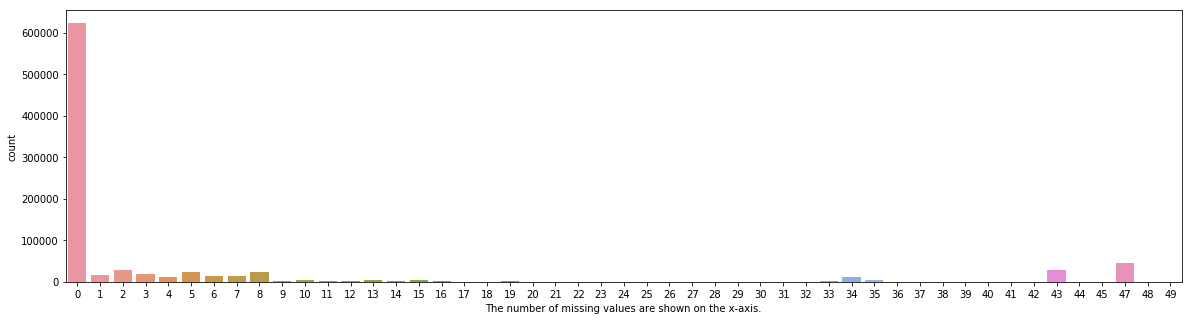

In [26]:
# The chart below displays the number of rows by number of missing values.
plt.figure(figsize=(20,5))
ax = sns.countplot(azdias.isnull().sum(axis=1))
ax.set_xlabel('The number of missing values are shown on the x-axis.')
plt.show()


In [27]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
AzdiasRows_20OrLessMissing = azdias[azdias['Missing_Data'] <= 20]
AzdiasRows_Over20Missing = azdias[azdias['Missing_Data'] > 20]

In [28]:
# Drop the helper feature
AzdiasRows_20OrLessMissing = AzdiasRows_20OrLessMissing.drop('Missing_Data', axis = 1)
AzdiasRows_Over20Missing = AzdiasRows_Over20Missing.drop('Missing_Data', axis = 1)
azdias = azdias.drop('Missing_Data', axis = 1)

In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plot(column_name):
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    sns.set(style="darkgrid")
    ax = sns.countplot(x = column_name, data=AzdiasRows_20OrLessMissing)
    plt.title("Group 1: <= 20 Missing Value")
    plt.subplot(122)
    sns.set(style="darkgrid")
    ax = sns.countplot(x = column_name, data=AzdiasRows_Over20Missing)
    plt.title("Group 2: > 20 Missing Value")
    plt.tight_layout()

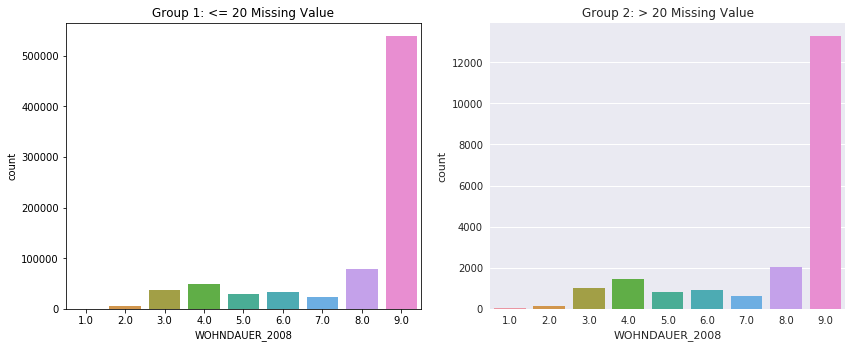

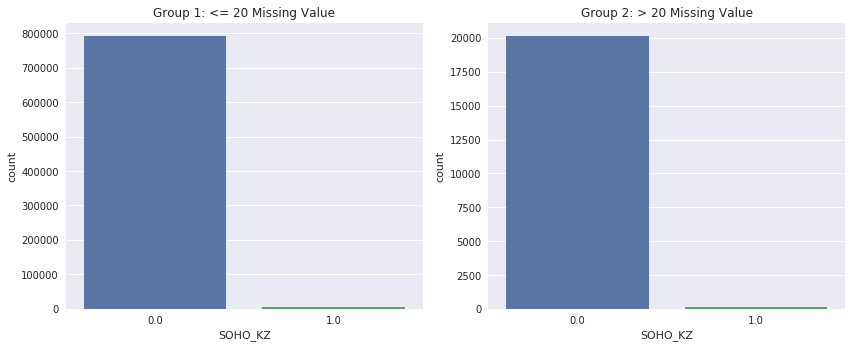

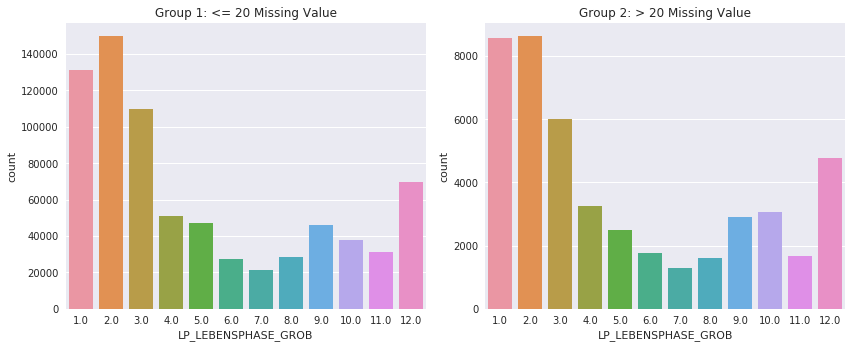

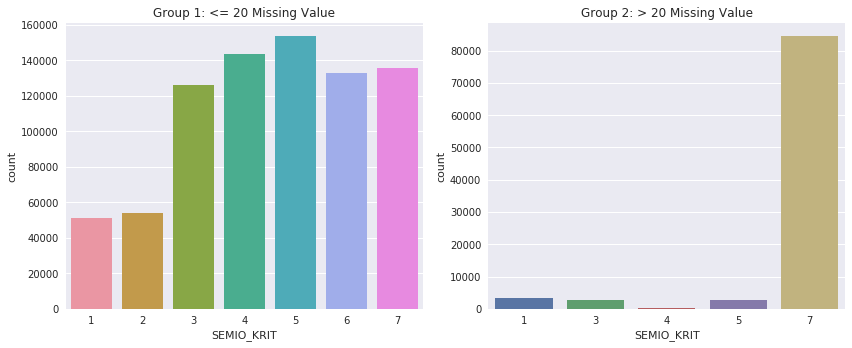

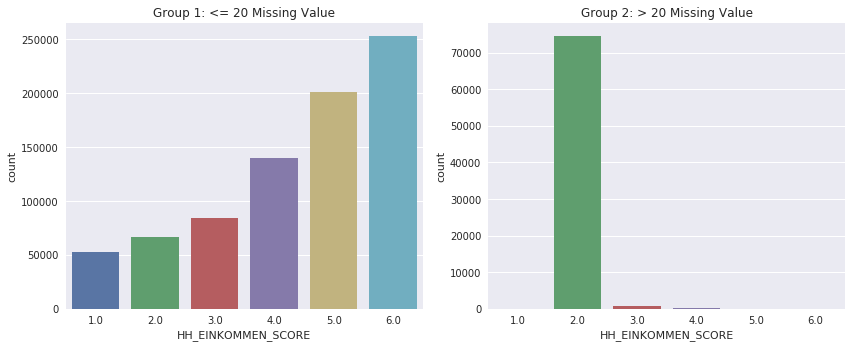

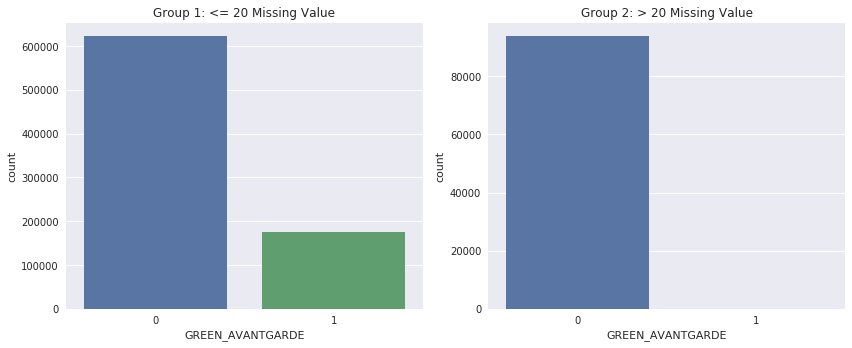

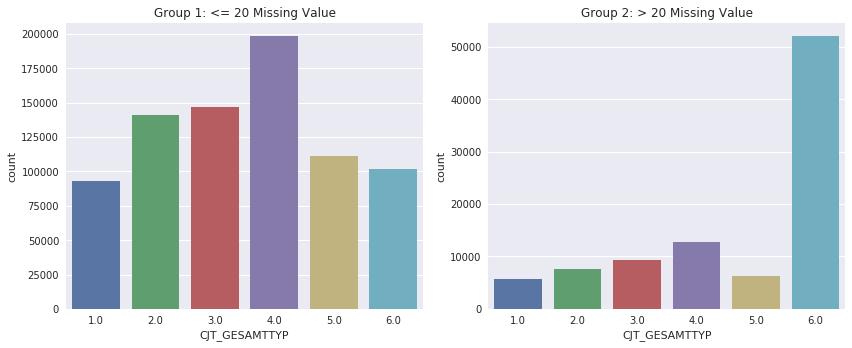

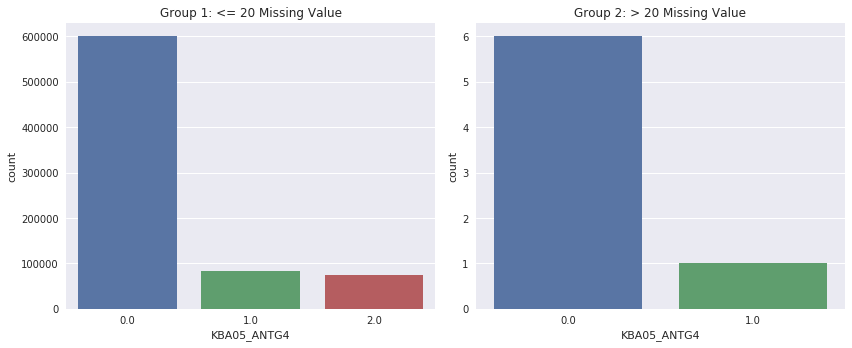

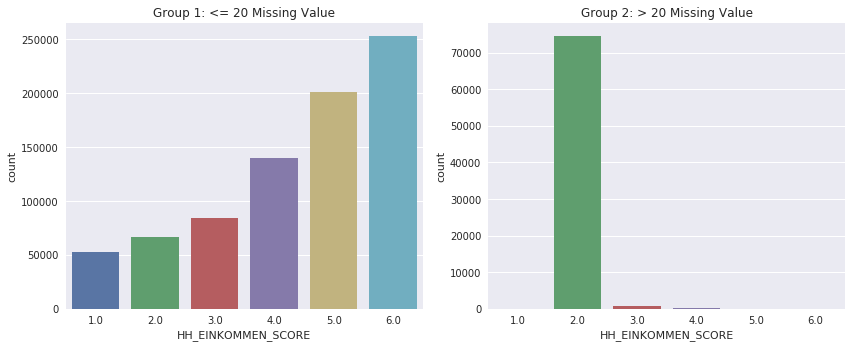

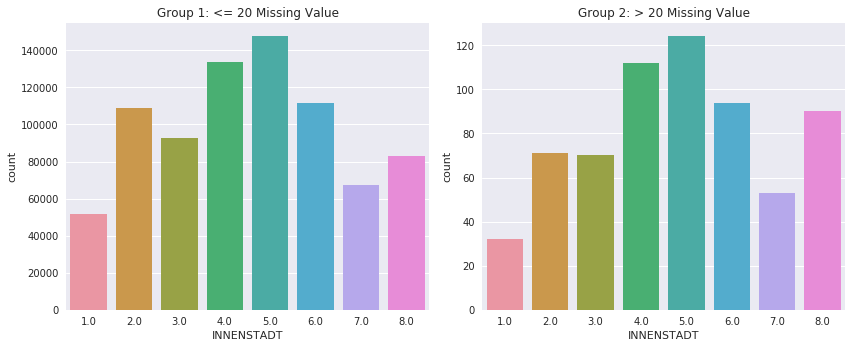

In [30]:
for i in range(10):
    plot(azdias.columns[random.randint(0, 79)])

#### _Discussion 1.1.3: Assess Missing Data in Each Row_

_Report your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)_

The data points with many missing values on their rows are considerably different from the data points with few or no missing values.

In nearly half the cases, there is one data point under each field that contains a disproportionately high number of missing values on their rows.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [31]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [32]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

feat_info[feat_info['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [33]:
azdias['OST_WEST_KZ'].value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

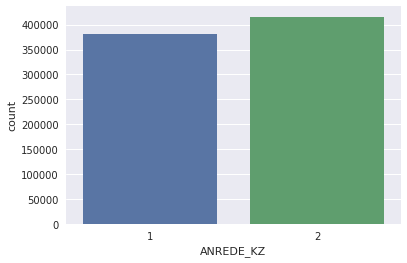

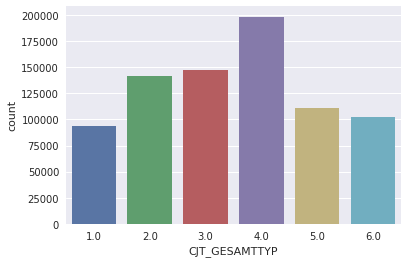

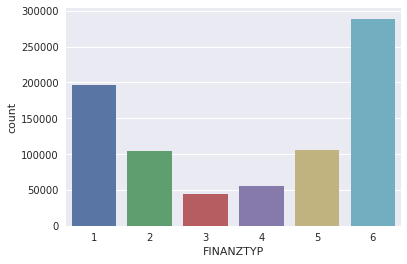

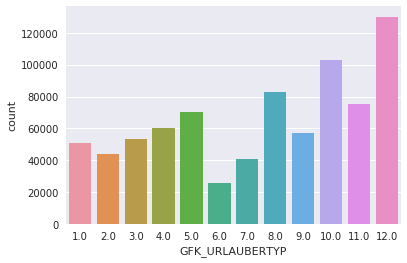

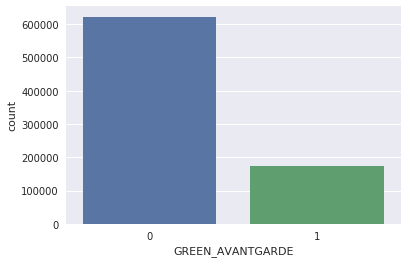

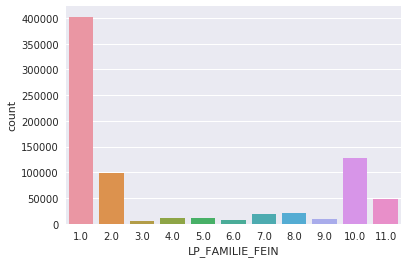

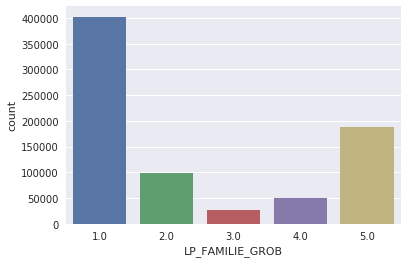

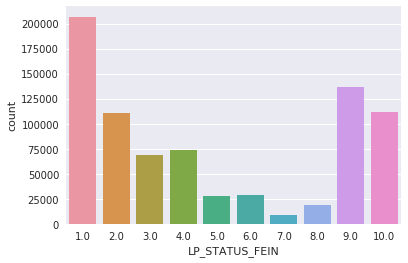

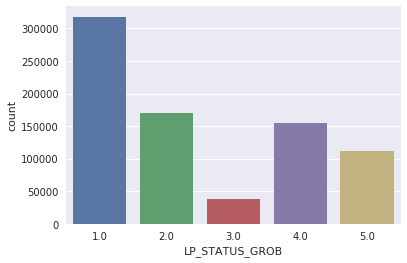

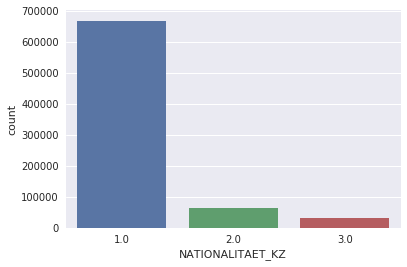

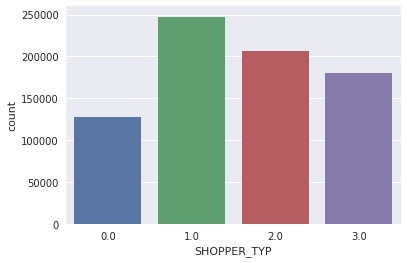

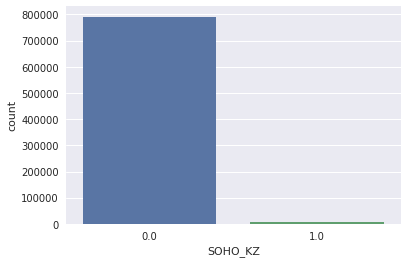

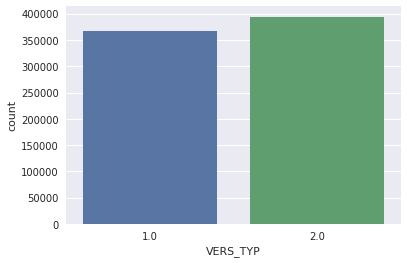

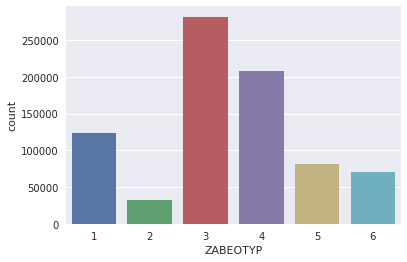

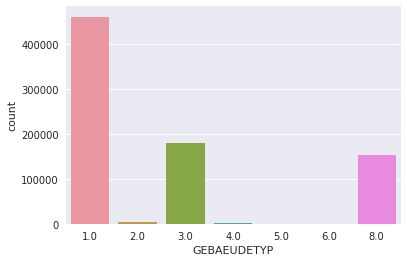

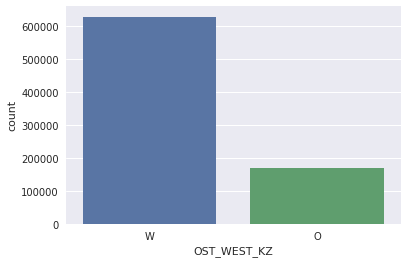

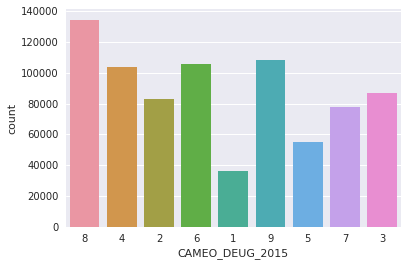

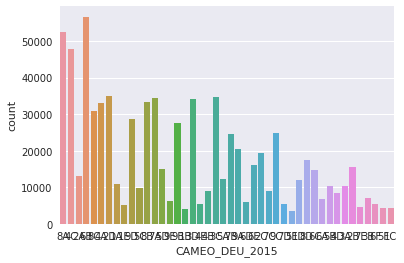

In [34]:
# Re-encode categorical variable(s) to be kept in the analysis.

for attribute in feat_info[feat_info['type'] == 'categorical']['attribute']:
    sns.set(style="darkgrid")
    ax = sns.countplot(x = attribute, data=AzdiasRows_20OrLessMissing)
    plt.show()

In [35]:

AzdiasRows_20OrLessMissing = pd.get_dummies(AzdiasRows_20OrLessMissing, columns = ['CJT_GESAMTTYP','FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 
                                               'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'OST_WEST_KZ'])

In [36]:
Azdias_Encoded = AzdiasRows_20OrLessMissing.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], axis = 1)

#### _Discussion 1.2.1: Re-Encode Categorical Features_

_Report your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?_

I kept the following fields because they either contained binary values or floats (numbers with decimals):
-  ANREDE_KZ
-  CJT_GESAMTTYP
-  FINANZTYP
-  GREEN_AVANTGARDE
-  LP_FAMILIE_FEIN
-  LP_STATUS_GROB
-  NATIONALITAET_KZ
-  SHOPPER_TYP
-  SOHO_KZ
-  VERS_TYP
-  ZABEOTYP
-  OST_WEST_KZ

I dropped the following fields because each field contained multiple attributes:
-  GFK_URLAUBERTYP
-  LP_FAMILIE_FEIN
-  LP_STATUS_FEIN
-  GEBAEUDETYP
-  CAMEO_DEUG_2015
-  CAMEO_DEU_2015


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [37]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [38]:
# Engineer New Features for "PRAEGENDE_JUGENDJAHRE"
def New_Praegende_Jugendjahre_Fields(Azdias_Encoded):
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 1.0, 'Decade'] = '40s'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 1.0, 'Movement'] = 'MainStream'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 1.0, 'Nation'] = 'E+W'

    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 2.0, 'Decade'] = '40s'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 2.0, 'Movement'] = 'Avantgarde'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 2.0, 'Nation'] = 'E+W'

    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 3.0, 'Decade'] = '50s'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 3.0, 'Movement'] = 'MainStream'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 3.0, 'Nation'] = 'E+W'

    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 4.0, 'Decade'] = '50s'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 4.0, 'Movement'] = 'Avantgarde'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 4.0, 'Nation'] = 'E+W'

    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 5.0, 'Decade'] = '60s'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 5.0, 'Movement'] = 'MainStream'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 5.0, 'Nation'] = 'E+W'

    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 6.0, 'Decade'] = '60s'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 6.0, 'Movement'] = 'Avantgarde'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 6.0, 'Nation'] = 'W'

    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 7.0, 'Decade'] = '60s'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 7.0, 'Movement'] = 'Avantgarde'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 7.0, 'Nation'] = 'E'

    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 8.0, 'Decade'] = '70s'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 8.0, 'Movement'] = 'MainStream'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 8.0, 'Nation'] = 'E+W'

    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 9.0, 'Decade'] = '70s'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 9.0, 'Movement'] = 'Avantgarde'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 9.0, 'Nation'] = 'E+W'

    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 10.0, 'Decade'] = '80s'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 10.0, 'Movement'] = 'MainStream'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 10.0, 'Nation'] = 'W'

    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 11.0, 'Decade'] = '80s'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 11.0, 'Movement'] = 'Avantgarde'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 11.0, 'Nation'] = 'W'

    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 12.0, 'Decade'] = '80s'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 12.0, 'Movement'] = 'MainStream'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 12.0, 'Nation'] = 'E'

    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 13.0, 'Decade'] = '80s'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 13.0, 'Movement'] = 'Avantgarde'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 13.0, 'Nation'] = 'E'

    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 14.0, 'Decade'] = '90s'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 14.0, 'Movement'] = 'MainStream'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 14.0, 'Nation'] = 'E+W'

    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 15.0, 'Decade'] = '90s'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 15.0, 'Movement'] = 'Avantgarde'
    Azdias_Encoded.loc[Azdias_Encoded['PRAEGENDE_JUGENDJAHRE'] == 15.0, 'Nation'] = 'E+W'
    
    return Azdias_Encoded

In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.


In [40]:
Azdias_Encoded = New_Praegende_Jugendjahre_Fields(Azdias_Encoded)

In [41]:
# One-hot encode the 3 new features
Azdias_Encoded = pd.get_dummies(Azdias_Encoded, columns = ['Decade', 'Movement', 'Nation'])
# Drop the original feature
Azdias_Encoded = Azdias_Encoded.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)

In [42]:
# Change data type to float
def New_Cameo_Intl_2015_Fields(Azdias_Encoded):
    Azdias_Encoded["CAMEO_INTL_2015"] = Azdias_Encoded["CAMEO_INTL_2015"].astype(float)

    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    Azdias_Encoded.loc[Azdias_Encoded["CAMEO_INTL_2015"] // 10 == 1.0, 'Wealth'] = 'Wealthy Households'
    Azdias_Encoded.loc[Azdias_Encoded["CAMEO_INTL_2015"] // 10 == 2.0, 'Wealth'] = 'Prosperous Households'
    Azdias_Encoded.loc[Azdias_Encoded["CAMEO_INTL_2015"] // 10 == 3.0, 'Wealth'] = 'Comfortable Households'
    Azdias_Encoded.loc[Azdias_Encoded["CAMEO_INTL_2015"] // 10 == 4.0, 'Wealth'] = 'Less Affluent Households'
    Azdias_Encoded.loc[Azdias_Encoded["CAMEO_INTL_2015"] // 10 == 5.0, 'Wealth'] = 'Poorer Households'

    Azdias_Encoded.loc[Azdias_Encoded["CAMEO_INTL_2015"] % 10 == 1.0, 'Life_Stage'] = 'Pre-Family Couples & Singles'
    Azdias_Encoded.loc[Azdias_Encoded["CAMEO_INTL_2015"] % 10 == 2.0, 'Life_Stage'] = 'Young Couples With Children'
    Azdias_Encoded.loc[Azdias_Encoded["CAMEO_INTL_2015"] % 10 == 3.0, 'Life_Stage'] = 'Families With School Age Children'
    Azdias_Encoded.loc[Azdias_Encoded["CAMEO_INTL_2015"] % 10 == 4.0, 'Life_Stage'] = 'Older Families &  Mature Couples'
    Azdias_Encoded.loc[Azdias_Encoded["CAMEO_INTL_2015"] % 10 == 5.0, 'Life_Stage'] = 'Elders In Retirement'
    return Azdias_Encoded

In [43]:
Azdias_Encoded = New_Cameo_Intl_2015_Fields(Azdias_Encoded)

In [44]:
# One-hot encode the 2 new features
Azdias_Encoded = pd.get_dummies(Azdias_Encoded, columns = ['Wealth', 'Life_Stage'])
# Drop the original feature
Azdias_Encoded = Azdias_Encoded.drop('CAMEO_INTL_2015', axis = 1)

In [45]:
# Drop Other Features
Azdias_Encoded.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 
                              'WOHNLAGE', 'PLZ8_BAUMAX'],
                   axis = 1, inplace = True)

#### _Discussion 1.2.2: Engineer Mixed-Type Features_

_Report your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?_

I created new columns with attributes names that are assigned to the numbers under the “PRAEGENDE_JUGENDJAHRE” and “CAMEO_INTL_2015” columns. Next, I used the “get dummies” function under the Pandas package. After that, I dropped the original “PRAEGENDE_JUGENDJAHRE” and “CAMEO_INTL_2015” columns to prevent duplication issues.

I also dropped the other mixed features to maintain focus on the core goals of this large project. 
-  LP_LEBENSPHASE_FEIN
-  LP_LEBENSPHASE_GROB
-  WOHNLAGE
-  PLZ8_BAUMAX


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [46]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



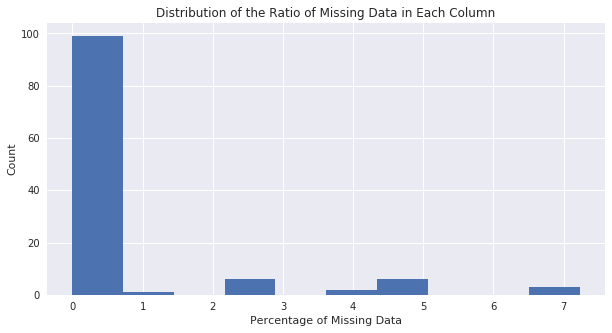

In [47]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

null_count = Azdias_Encoded.isnull().sum()
null_percent = null_count / len(azdias) * 100
plt.figure(figsize=(10,5))
plt.title('Distribution of the Ratio of Missing Data in Each Column')
plt.hist(null_percent)
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Count')
plt.show()

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [48]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
    for i, column in enumerate(df.columns):
        str_n = feat_info['missing_or_unknown'].iloc[i]
        if i in [57, 58, 59]:
            list_n = str_n[1: -1].split(',')
        else:
            list_n = ast.literal_eval(str_n)
        for num in list_n:
            df[column].replace(num, np.NaN, inplace = True)
    
    # remove selected columns and rows, ...
    drop_columns = ['TITEL_KZ', 'AGER_TYP', 'GEBURTSJAHR', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(drop_columns, axis = 1, inplace = True)
    
    df['Missing_Data'] = df.isnull().sum(axis=1)
    dfRows_20OrLessMissing = df[df['Missing_Data'] <= 5]
    dfRows_20OrLessMissing = dfRows_20OrLessMissing.drop('Missing_Data', axis = 1)
    
    # select, re-encode, and engineer column values.
    dfRows_20OrLessMissing = pd.get_dummies(dfRows_20OrLessMissing, columns = ['CJT_GESAMTTYP','FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 
                                               'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'OST_WEST_KZ'])
    df = dfRows_20OrLessMissing.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], axis = 1)
    df = New_Praegende_Jugendjahre_Fields(df)
    df = pd.get_dummies(df, columns = ['Decade', 'Movement', 'Nation'])
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)
    df = New_Cameo_Intl_2015_Fields(df)
    df = pd.get_dummies(df, columns = ['Wealth', 'Life_Stage'])
    df = df.drop('CAMEO_INTL_2015', axis = 1)
    df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis = 1, inplace = True)
    
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [49]:
# To simplify the notation
df = Azdias_Encoded

In [50]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.


In [51]:
df.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,Wealth_Comfortable Households,Wealth_Less Affluent Households,Wealth_Poorer Households,Wealth_Prosperous Households,Wealth_Wealthy Households,Life_Stage_Elders In Retirement,Life_Stage_Families With School Age Children,Life_Stage_Older Families & Mature Couples,Life_Stage_Pre-Family Couples & Singles,Life_Stage_Young Couples With Children
count,794642.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,761009.000000,...,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000,797426.000000
mean,2.795323,1.521404,3.058918,2.715689,3.433056,2.840544,2.657258,3.115095,0.219666,2.199180,...,0.085427,0.238147,0.280309,0.238904,0.149684,0.146707,0.149931,0.291764,0.307190,0.096880
std,1.018525,0.499542,1.377564,1.485055,1.376977,1.472576,1.399161,1.407890,0.414020,0.755144,...,0.279517,0.425950,0.449151,0.426414,0.356762,0.353814,0.357004,0.454574,0.461329,0.295795
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
# Apply feature scaling to the general population demographics data.

ImputeMedian = Imputer(missing_values=float("NaN"), strategy="median", axis=1, copy = False)
NewScale = StandardScaler()

In [53]:
df[df.columns] = NewScale.fit_transform(ImputeMedian.fit_transform(df))

In [54]:
# Check all 'NAN's are transformed or not
df.isnull().sum().sum()

0

In [55]:
# Check StandardScalar
df.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,Wealth_Comfortable Households,Wealth_Less Affluent Households,Wealth_Poorer Households,Wealth_Prosperous Households,Wealth_Wealthy Households,Life_Stage_Elders In Retirement,Life_Stage_Families With School Age Children,Life_Stage_Older Families & Mature Couples,Life_Stage_Pre-Family Couples & Singles,Life_Stage_Young Couples With Children
count,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,...,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05,7.974260e+05
mean,9.209845e-17,8.277811e-17,1.346548e-16,-8.425725e-17,-3.776250e-17,-9.630418e-17,1.835286e-16,-8.126334e-17,-1.561111e-17,8.415032e-17,...,-7.901790e-17,4.052029e-17,8.527304e-17,1.034771e-16,-4.774221e-17,-2.330975e-17,-4.601358e-17,-5.473692e-17,1.334786e-17,-1.012228e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.728110e+00,-1.043765e+00,-1.494609e+00,-1.155304e+00,-1.766955e+00,-1.249881e+00,-1.184467e+00,-1.502317e+00,-5.305674e-01,-2.691713e+00,...,-3.056254e-01,-5.590975e-01,-6.240881e-01,-5.602626e-01,-4.195635e-01,-4.146449e-01,-4.199706e-01,-6.418397e-01,-6.658802e-01,-3.275258e-01
25%,-7.717865e-01,-1.043765e+00,-7.686897e-01,-1.155304e+00,-1.040726e+00,-1.249881e+00,-1.184467e+00,-7.920337e-01,-5.305674e-01,-1.724615e-01,...,-3.056254e-01,-5.590975e-01,-6.240881e-01,-5.602626e-01,-4.195635e-01,-4.146449e-01,-4.199706e-01,-6.418397e-01,-6.658802e-01,-3.275258e-01
50%,2.063751e-01,9.580705e-01,-4.276997e-02,1.914482e-01,4.117312e-01,1.082835e-01,-4.697522e-01,-8.175029e-02,-5.305674e-01,-1.724615e-01,...,-3.056254e-01,-5.590975e-01,-6.240881e-01,-5.602626e-01,-4.195635e-01,-4.146449e-01,-4.199706e-01,-6.418397e-01,-6.658802e-01,-3.275258e-01
75%,1.184537e+00,9.580705e-01,6.831497e-01,8.648242e-01,1.137960e+00,7.873659e-01,9.596769e-01,6.285331e-01,-5.305674e-01,1.087164e+00,...,-3.056254e-01,-5.590975e-01,1.602338e+00,-5.602626e-01,-4.195635e-01,-4.146449e-01,-4.199706e-01,1.558021e+00,1.501772e+00,-3.275258e-01
max,1.184537e+00,9.580705e-01,1.409069e+00,1.538200e+00,1.137960e+00,1.466448e+00,1.674391e+00,1.338816e+00,1.884775e+00,1.087164e+00,...,3.271980e+00,1.788597e+00,1.602338e+00,1.784877e+00,2.383429e+00,2.411702e+00,2.381119e+00,1.558021e+00,1.501772e+00,3.053195e+00


In [56]:
np.median(df, axis=0)

array([ 0.20637506,  0.9580705 , -0.04276997,  0.1914482 ,  0.41173119,
        0.10828346, -0.46975219, -0.08175029, -0.53056739, -0.17246153,
        0.39085781, -0.07249275, -0.05910109,  0.00329359,  0.05912705,
        0.37141066,  0.31675005, -0.3406881 , -0.06763906,  0.0643565 ,
        0.25640424,  0.24407629, -0.15750909, -0.09940188,  0.15590177,
       -0.09213322, -0.94813777, -0.63076034, -0.06056999,  0.37888327,
        0.04047535,  0.56671422, -0.27505648, -0.136393  , -0.01466949,
       -0.38315997, -0.34031552, -0.20578859, -0.64656272, -0.52863085,
       -0.03578802,  0.38878873,  0.03648392,  0.22328055,  0.28359196,
        0.39648852,  0.09308775,  0.17818396,  0.40477721, -0.19416563,
       -0.21886518,  0.26208913,  0.43245761,  0.40963642, -0.50578702,
       -0.26576634, -0.15384113, -0.11702042, -0.04399917, -0.3639324 ,
       -0.46388791, -0.47566623, -0.57505754, -0.40225033, -0.38288183,
       -0.57259388, -0.38874422, -0.24359623, -0.27452647, -0.39

### _Discussion 2.1: Apply Feature Scaling_

_Report your decisions regarding feature scaling._

I replaced the missing values under each field with the “median” value of each field. In cases like this, I tend to use medians rather than means to avoid the skewing effects that outliers in datasets can cause in analysis.

Next, I used “StandardScaler,” as recommended in the project notes, which will scale numerical values under each field so that each field will have a mean of 0 and a standard deviation of 1. This results in a scale of “-1 to 1” with 0 as the mean for each field containing only numerical values. This allows clustering models to work effectively.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [57]:
# Apply PCA to the data.

pca = PCA()
df_pca = pca.fit_transform(df)

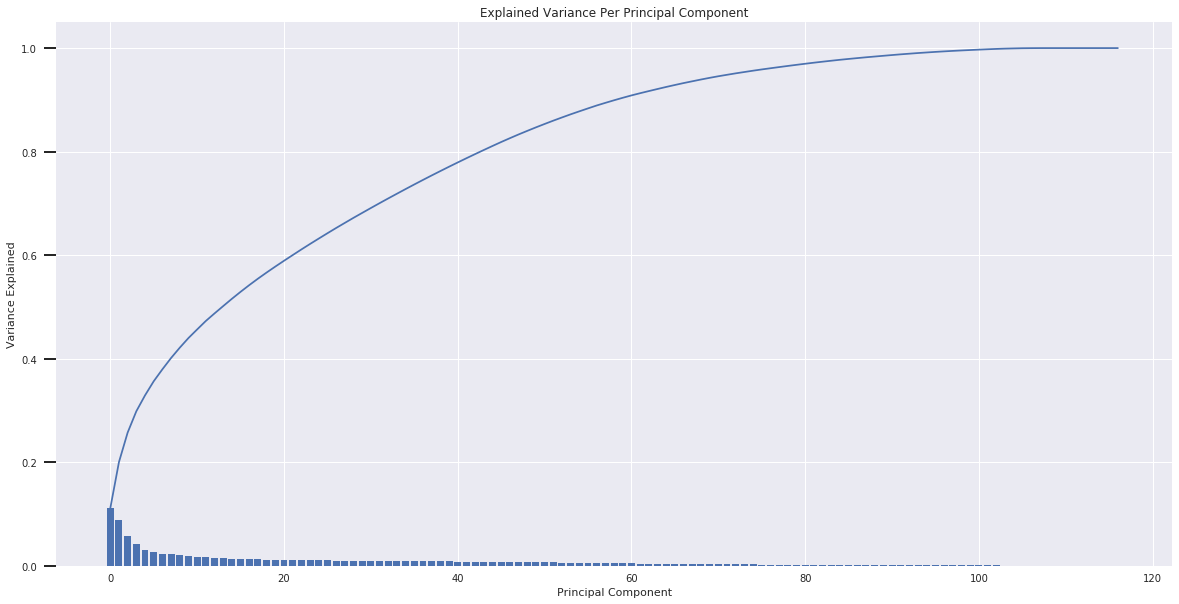

In [58]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained")
    plt.title('Explained Variance Per Principal Component')


scree_plot(pca)

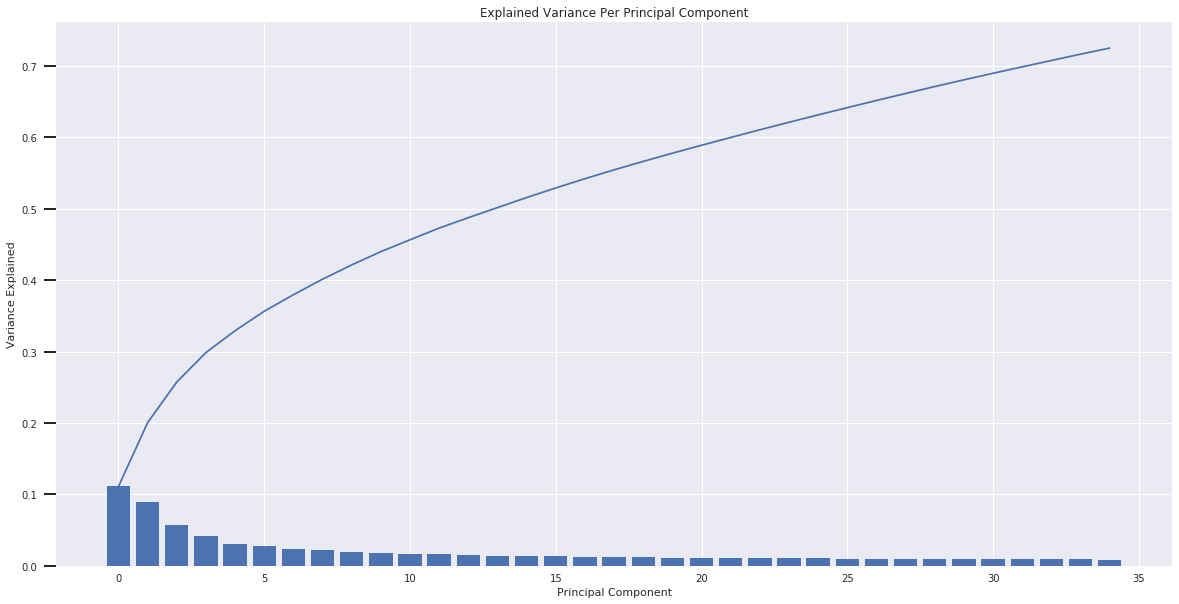

In [59]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(35)
df_pca = pca.fit_transform(df)
scree_plot(pca)

### _Discussion 2.2: Perform Dimensionality Reduction_

_Report your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?_

I’m retaining 35 principal components / transformed features since they cumulatively explain well over 70% of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [60]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def print_weights(n):
    '''
    n: number of principal component
    '''
    Component_Weight = pd.DataFrame(np.round(pca.components_[n - 1: n], 4), columns = df.keys())
    Component_Weight.index = ['Weights']
    Component_Weight = Component_Weight.sort_values(by = 'Weights', axis = 1, ascending=False)
    Component_Weight = Component_Weight.T
    print(Component_Weight)
    return Component_Weight

In [61]:
Component_Weight_1 = print_weights(1)

                                             Weights
LP_STATUS_GROB_1.0                            0.1999
HH_EINKOMMEN_SCORE                            0.1868
PLZ8_ANTG3                                    0.1805
PLZ8_ANTG4                                    0.1760
FINANZ_SPARER                                 0.1676
ORTSGR_KLS9                                   0.1532
EWDICHTE                                      0.1521
FINANZTYP_1                                   0.1467
Wealth_Poorer Households                      0.1460
Life_Stage_Pre-Family Couples & Singles       0.1404
FINANZ_HAUSBAUER                              0.1391
SEMIO_PFLICHT                                 0.1301
SEMIO_REL                                     0.1259
KBA05_ANTG4                                   0.1182
KBA05_ANTG3                                   0.1161
PLZ8_ANTG2                                    0.1157
Decade_90s                                    0.1147
ARBEIT                                        

In [62]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

Component_Weight_2 = print_weights(2)

                              Weights
ALTERSKATEGORIE_GROB           0.2109
ZABEOTYP_3                     0.2032
FINANZ_VORSORGER               0.1974
SEMIO_ERL                      0.1809
SEMIO_LUST                     0.1491
RETOURTYP_BK_S                 0.1486
FINANZ_HAUSBAUER               0.1319
W_KEIT_KIND_HH                 0.1150
PLZ8_ANTG3                     0.1138
PLZ8_ANTG4                     0.1076
Decade_60s                     0.1035
EWDICHTE                       0.1019
ORTSGR_KLS9                    0.1019
CJT_GESAMTTYP_2.0              0.0982
Decade_50s                     0.0968
HH_EINKOMMEN_SCORE             0.0914
SEMIO_KRIT                     0.0911
FINANZTYP_5                    0.0908
Wealth_Poorer Households       0.0863
SEMIO_KAEM                     0.0858
ARBEIT                         0.0833
ANZ_HAUSHALTE_AKTIV            0.0762
PLZ8_ANTG2                     0.0752
RELAT_AB                       0.0751
LP_STATUS_GROB_1.0             0.0732
KBA05_ANTG4 

In [63]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

Component_Weight_3 = print_weights(3)

                                         Weights
SEMIO_VERT                                0.3224
SEMIO_SOZ                                 0.2571
SEMIO_FAM                                 0.2561
SEMIO_KULT                                0.2445
FINANZTYP_5                               0.1412
FINANZ_MINIMALIST                         0.1290
SHOPPER_TYP_0.0                           0.1218
ZABEOTYP_1                                0.1042
SEMIO_REL                                 0.0989
RETOURTYP_BK_S                            0.0889
SEMIO_MAT                                 0.0794
W_KEIT_KIND_HH                            0.0783
ORTSGR_KLS9                               0.0680
EWDICHTE                                  0.0669
FINANZ_VORSORGER                          0.0662
PLZ8_ANTG3                                0.0607
PLZ8_ANTG4                                0.0605
GREEN_AVANTGARDE                          0.0587
Movement_Avantgarde                       0.0587
ZABEOTYP_6          

### Discussion 2.3: Interpret Principal Components

Report your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?

I was able to interpret postive and negative values for each field. However, it seems that using the k-means approach is much easier for deriving meaning.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [64]:
def score(data, k):
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))

In [65]:
scores = []
centers = np.linspace(1,15,15)
for i in range(1, 16):
    scores.append(score(df_pca, i))

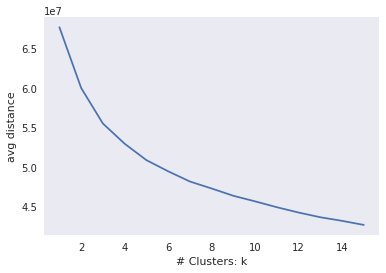

In [66]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

fig, ax = plt.subplots()
ax.plot(centers, scores)
ax.set(ylabel='Average Distance', xlabel='# of Clusters: k')
ax.grid()
plt.xticks(np.arange(2,15,2))
plt.show()

In [67]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_k = KMeans(7)
model_k = kmeans_k.fit(df_pca)
Prediction_Azdias_PCA = model_k.predict(df_pca)

### _Discussion 3.1: Apply Clustering to General Population_

_Report your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?_

I used the elbow method to determine that 7 clusters would be optimal for this analysis. After around the "7" mark on chart showing the distances between clusters, the distances do not experience much change as the number of clusters increase.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [68]:
# Load in the customer demographics data.
Customer_Data = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
Len_Customer_Data = len(Customer_Data)

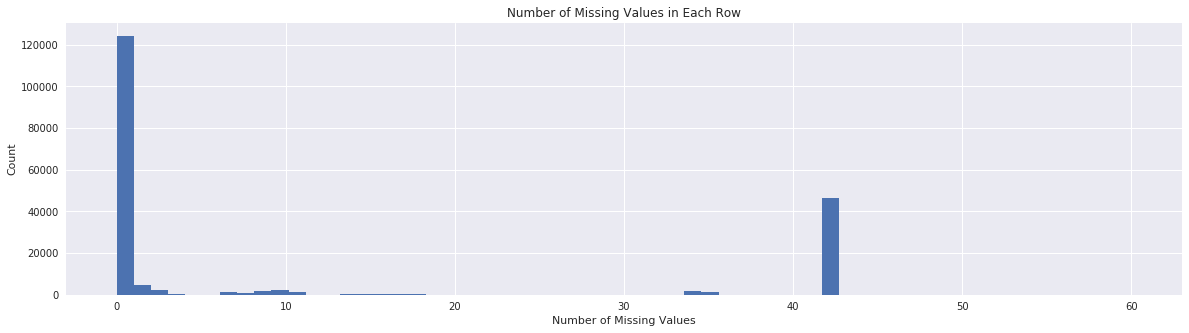

In [69]:
plt.figure(figsize=(20,5))
plt.title('Number of Missing Values in Each Row')
plt.hist(Customer_Data.isnull().sum(axis = 1), bins = np.linspace(0,60,60))
plt.xlabel('Number of Missing Values')
plt.ylabel('Count')
plt.show()

In [70]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

Customer_Data = clean_data(Customer_Data)
Customer_Data[Customer_Data.columns] = NewScale.transform(ImputeMedian.transform(Customer_Data))
Customer_Data_PCA = pca.transform(Customer_Data)
Prediction_Customer_Data_PCA = model_k.predict(Customer_Data_PCA)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [96]:
Prediction_Azdias_Data_Ratio = np.append(Prediction_Azdias_PCA, [7] * (len(azdias) - len(Prediction_Azdias_PCA)))

In [97]:
Prediction_Customers_Data_Ratio = np.append(Prediction_Customer_Data_PCA, [7] * (len(Customer_Data) - len(Prediction_Customer_Data_PCA)))

In [98]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def plot_distribution(df, column, height):
    ncount = len(df)
    plt.figure(figsize=(14,6))
    ax = sns.countplot(x = column, data = df)
    plt.title('Distribution of Each Cluster')
    plt.xlabel('Clusters')

    # Make twin axis
    ax2=ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency %')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))

    # Fix the frequency range to 0-100
    ratio = 100 / height
    ax2.set_ylim(0,100 / ratio)
    ax.set_ylim(0,ncount / ratio)

    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)

In [99]:
df_Prediction_Azdias_Data_Ratio = pd.DataFrame(Prediction_Azdias_Data_Ratio, columns = ['Cluster'])
df_Prediction_Customers_Data_Ratio = pd.DataFrame(Prediction_Customers_Data_Ratio, columns = ['Cluster'])

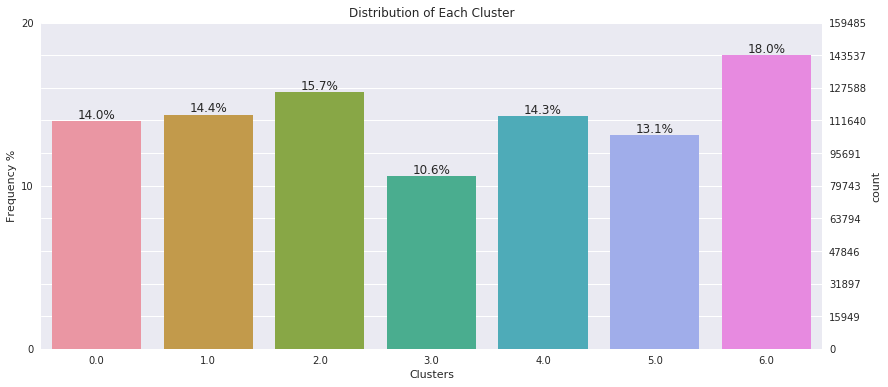

In [100]:
plot_distribution(df_Prediction_Azdias_Data_Ratio, 'Cluster', height = 20)

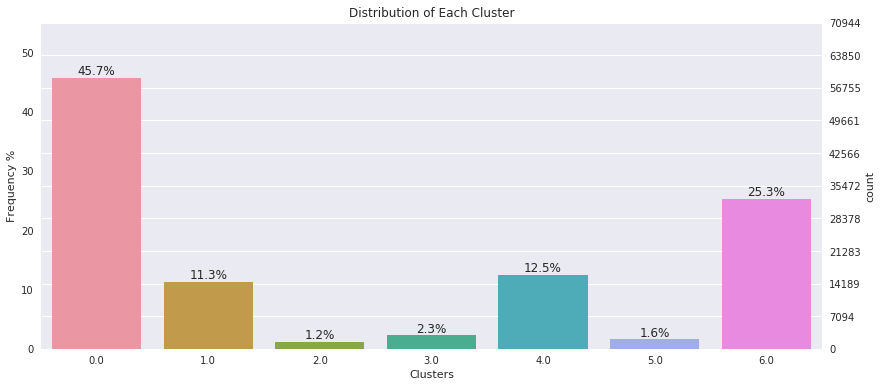

In [101]:
plot_distribution(df_Prediction_Customers_Data_Ratio, 'Cluster', height = 55)

In [102]:
def drop_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
    for i, column in enumerate(df.columns):
        str_n = feat_info['missing_or_unknown'].iloc[i]
        if i in [57, 58, 59]:
            list_n = str_n[1: -1].split(',')
        else:
            list_n = ast.literal_eval(str_n)
        for num in list_n:
            df[column].replace(num, np.NaN, inplace = True)
    
    # remove selected columns and rows, ...
    drop_columns = ['TITEL_KZ', 'AGER_TYP', 'GEBURTSJAHR', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(drop_columns, axis = 1, inplace = True)
    
    df['Missing_Data'] = df.isnull().sum(axis=1)
    dfRows_20OrLessMissing = df[df['Missing_Data'] <= 20]
    dfRows_20OrLessMissing = dfRows_20OrLessMissing.drop('Missing_Data', axis = 1)
    dfRows_20OrLessMissing = New_Praegende_Jugendjahre_Fields(dfRows_20OrLessMissing)
    dfRows_20OrLessMissing = New_Cameo_Intl_2015_Fields(dfRows_20OrLessMissing)
    return dfRows_20OrLessMissing

In [103]:
# Reload dataset and do column/row dropping
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
azdias = drop_data(azdias)
customers = drop_data(customers)

In [108]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

target_list = df_Prediction_Customers_Data_Ratio[df_Prediction_Customers_Data_Ratio['Cluster'] == 0].index
df_target = customers.iloc[target_list]
df_target.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Decade,Movement,Nation,Wealth,Life_Stage
0,4.0,1,5.0,5,1,5,1,2,2,2,...,5.0,5.0,1.0,2.0,1.0,50s,Avantgarde,E+W,Wealthy Households,Families With School Age Children
2,4.0,2,2.0,5,1,5,1,4,4,2,...,3.0,2.0,3.0,5.0,3.0,50s,Avantgarde,E+W,Comfortable Households,Older Families & Mature Couples
4,3.0,1,6.0,3,1,4,4,5,2,2,...,3.0,3.0,3.0,5.0,1.0,70s,MainStream,E+W,Less Affluent Households,Pre-Family Couples & Singles
5,3.0,1,4.0,5,1,5,1,2,3,5,...,5.0,5.0,3.0,7.0,5.0,50s,Avantgarde,E+W,Comfortable Households,Older Families & Mature Couples
6,4.0,1,2.0,5,1,5,1,1,2,2,...,5.0,5.0,2.0,3.0,2.0,50s,Avantgarde,E+W,Prosperous Households,Families With School Age Children


In [109]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

outside_list = df_Prediction_Azdias_Data_Ratio[df_Prediction_Azdias_Data_Ratio['Cluster'] == 2].index
df_outside = azdias.iloc[outside_list]
df_outside.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,Decade,Movement,Nation,Wealth,Life_Stage
1,1.0,2,5.0,1,5,2,5,4,5,1,...,5.0,4.0,3.0,5.0,4.0,90s,MainStream,E+W,Poorer Households,Pre-Family Couples & Singles
22,1.0,1,4.0,1,5,3,5,5,5,1,...,4.0,3.0,4.0,5.0,5.0,90s,MainStream,E+W,Poorer Households,Pre-Family Couples & Singles
31,2.0,2,6.0,1,5,2,3,5,4,1,...,4.0,2.0,4.0,8.0,5.0,80s,MainStream,W,Poorer Households,Pre-Family Couples & Singles
52,1.0,2,1.0,1,4,2,2,4,3,1,...,5.0,3.0,4.0,9.0,3.0,90s,MainStream,E+W,Less Affluent Households,Pre-Family Couples & Singles
57,1.0,2,4.0,1,5,3,5,3,5,1,...,4.0,3.0,4.0,8.0,4.0,90s,MainStream,E+W,Less Affluent Households,Pre-Family Couples & Singles


In [110]:
def plot_comparison(column):
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
    sns.countplot(x = column, data=df_target, ax=ax1)
    ax1.set_xlabel('Value')
    ax1.set_title('Distribution of target population')
    sns.countplot(x = column, data=df_outside, ax=ax2)
    ax2.set_xlabel('Value')
    ax2.set_title('Distribution of non-target population')
    fig.tight_layout()
    plt.show()

In [111]:
TargetMinusOutside = np.mean(df_target, axis=0) - np.mean(df_outside, axis=0)
TargetMinusOutsideOver2 = TargetMinusOutside[TargetMinusOutside > 2]
TargetMinusOutsideOver2

FINANZ_MINIMALIST        2.889847
FINANZ_VORSORGER         2.514544
FINANZTYP                2.190435
LP_LEBENSPHASE_FEIN     15.006356
LP_LEBENSPHASE_GROB      4.064758
LP_FAMILIE_FEIN          2.684031
LP_STATUS_FEIN           5.386151
LP_STATUS_GROB           2.468109
SEMIO_LUST               2.316848
KBA13_ANZAHL_PKW       168.179895
dtype: float64

In [112]:
OutsideMinusTarget = np.mean(df_outside, axis=0) - np.mean(df_target, axis=0) 
OutsideMinusTargetOver2 = OutsideMinusTarget[OutsideMinusTarget > 2]
OutsideMinusTargetOver2

FINANZ_SPARER             3.077741
FINANZ_ANLEGER            2.396378
GFK_URLAUBERTYP           2.115184
PRAEGENDE_JUGENDJAHRE     7.416497
SEMIO_REL                 2.566081
SEMIO_RAT                 2.371175
SEMIO_PFLICHT             2.883946
SEMIO_TRADV               2.209750
HH_EINKOMMEN_SCORE        2.372838
ANZ_HAUSHALTE_AKTIV      11.778355
CAMEO_INTL_2015          17.627618
dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

Report findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?

##### Based on my findings, the mail-order company should target the following types of people:
-  Live in a large metropolitan area
-  Relatively old in age
-  Houseowners – likely to live in wealthy or prosperous households
-  High-earners
-  Live in multi-person households
-  High amount of money saved


To derive these findings, I calculated the difference of the normalized numerical fields between the most over-represented cluster and the most under-represented cluster. I provided the numerical fields that had the most representation for each population segment below along with descriptions of those fields and summary of my findings. In the numerical fields, higher OR lower meant a characteristic was more predominant.

#### Segments of the population that are relatively popular with the mail-order company


-  KBA13_ANZAHL_PKW (+168.2): Number of cars in the PLZ8 region
-  LP_LEBENSPHASE_FEIN (+15.01): Life stage, fine scale
-  LP_STATUS_FEIN (+5.4): Social status, fine scale
-  LP_LEBENSPHASE_GROB (+4.1): Life stage, rough scale


_Summary of Findings:_
-  Likely live in a large metropolitan area due to higher number of cars in the surrounding area
-  Less likely to be single, more likely to be a parent and in a multi-person household
-  More likely to be a high-earner and/or houseowner


#### Segments of the population that are relatively unpopular with the mail-order company

-  CAMEO_INTL_2015 (+17.6): German CAMEO: Wealth / Life Stage Typology, mapped to international code
-  ANZ_HAUSHALTE_AKTIV (+11.8): Number of households in the building
-  PRAEGENDE_JUGENDJAHRE (+7.4): Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
-  FINANZ_SPARER (+3.08): Financial typology - SPARER: money-saver


_Summary of Findings:_
-  Less likely to live in a wealthy or prosperous household
-  More likely to live in apartment complexes
-  Usually younger in age
-  Less likely to be a money saver



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.